In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import numpy as np
import random
import time
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
np.random.seed(0)
X, Y = make_moons(500, noise=0.1)

# Split into test and training data
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.25, random_state=73)
y_train = np.reshape(y_train, (y_train.shape[0], 1))

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

In [3]:
np.shape(x_train)

(375, 2)

In [6]:
# Standard BP
model_bp = keras.Sequential(
    [
        keras.Input(shape=(2,)),
        #layers.Dense(100, activation = "sigmoid"),
        layers.Dense(100, activation = "sigmoid"),
        layers.Dense(1, activation = "sigmoid")
    ]
)
model_bp.summary()
#model_bp.get_weights()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_2 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 401
Trainable params: 401
Non-trainable params: 0
_________________________________________________________________


In [7]:
import time
batch_size = 32
epochs = 1500
opt = tf.keras.optimizers.SGD(learning_rate=0.1)

st = time.time()
model_bp.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
model_bp.fit(x_train, y_train, batch_size=batch_size, epochs=epochs)
print(time.time() - st)

Train on 375 samples
Epoch 1/1500
375/375 [==============================] - 1s 3ms/sample - loss: 0.7012 - accuracy: 0.5093
Epoch 2/1500
375/375 [==============================] - 0s 192us/sample - loss: 0.6610 - accuracy: 0.6480
Epoch 3/1500
375/375 [==============================] - 0s 165us/sample - loss: 0.6379 - accuracy: 0.6827
Epoch 4/1500
375/375 [==============================] - 0s 176us/sample - loss: 0.6144 - accuracy: 0.7680
Epoch 5/1500
375/375 [==============================] - 0s 143us/sample - loss: 0.5956 - accuracy: 0.7760
Epoch 6/1500
375/375 [==============================] - 0s 120us/sample - loss: 0.5743 - accuracy: 0.8000
Epoch 7/1500
375/375 [==============================] - 0s 116us/sample - loss: 0.5543 - accuracy: 0.8107
Epoch 8/1500
375/375 [==============================] - 0s 114us/sample - loss: 0.5397 - accuracy: 0.8000
Epoch 9/1500
375/375 [==============================] - 0s 103us/sample - loss: 0.5177 - accuracy: 0.8080
Epoch 10/1500
375/375 [====

In [8]:
#hmc

def convert2_zero_one(x):
    
    t = [tf.math.sigmoid(i) for i in x]
    
    return t

In [9]:
def rerange(x, r = 6.0):
    
    out_of_range = tf.cast(tf.math.greater(tf.math.abs(x), r), tf.float32)
    sign = tf.math.sign(x)
    
    return x * (1 - out_of_range) + sign * r * out_of_range

In [13]:
# MLP model
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
    
    def call(self, x):
        
        #x = Flatten()(x)
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y):
        
        h_current = convert2_zero_one([tf.cast(h_i, dtype=tf.float32) for h_i in h])
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob

    def target_log_prob2(self, x, h, y):

        h_current = convert2_zero_one(tf.split(h, self.hidden_layer_sizes, axis = 1))
        h_previous = [x] + h_current[:-1]
        
        nlog_prob = 0.
        
        for i, (cv, pv, layer) in enumerate(
            zip(h_current, h_previous, self.fc_layers)):
            
            ce = tf.nn.sigmoid_cross_entropy_with_logits(
                labels=cv, logits=layer(pv))
            
            nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = h_current[0]

        # initialize the HMC transition kernel
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob2(x, v, y),
            num_leapfrog_steps = 2,
            step_size = pow(1000, -1/4)),
            num_adaptation_steps=int(100*0.8))

        # run the chain (with burn-in)
        num_results = 1
        num_burnin_steps = 100

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = adaptive_hmc,
            trace_fn = None)

        h_new = tf.split(samples[0], self.hidden_layer_sizes, axis = 1)

        return(h_new)
    
    def update_weights(self, x, h, y, lr = 0.1):
        
        optimizer = tf.keras.optimizers.SGD(learning_rate = lr)
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y))
        
        grads = tape.gradient(loss, self.trainable_weights)
        optimizer.apply_gradients(zip(grads, self.trainable_weights))

    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tf.math.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tf.math.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tf.math.greater(probs, 0.5), tf.int32)

        return labels

In [14]:
model = StochasticMLP(hidden_layer_sizes = [100], n_outputs=1)

In [15]:
network = [model.call(images) for images, labels in train_ds]


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [16]:
kernels = [model.generate_hmc_kernel(images, labels) for images, labels in train_ds]

In [17]:
burnin = 1000
step_sizes = []
for i in range(burnin):
    
    print("Step %d" % i)
    network_new = []
    kernels_new = []
    
    for (images, labels), net, hmc_kernel in zip(train_ds, network, kernels):
        net_current = net
        net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
        net_current = net_current[0]
        
        num_results = 1
        num_burnin_steps = 0

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = net_current, # may need to be reshaped
            kernel = hmc_kernel,
            #trace_fn = lambda _, pkr: pkr.inner_results.accepted_results.new_step_size,
            trace_fn = None,
            return_final_kernel_results = True)
        
        #print(samples[2].new_step_size.numpy())
        new_step_size = samples[2][4].numpy()
        step_sizes.append(new_step_size)
        
        new_state = rerange(samples[0][0])
        net_new = tf.split(new_state, [100], axis = 1)   
        network_new.append(net_new)
        
        # build new kernel
        ker_new = model.generate_hmc_kernel(images, labels, new_step_size)
        kernels_new.append(ker_new)
            
    network = network_new
    kernels = kernels_new
    
    #print(network[0])

Step 0
Step 1
Step 2
Step 3
Step 4
Step 5
Step 6
Step 7
Step 8
Step 9
Step 10
Step 11
Step 12
Step 13
Step 14
Step 15
Step 16
Step 17
Step 18
Step 19
Step 20
Step 21
Step 22
Step 23
Step 24
Step 25
Step 26
Step 27
Step 28
Step 29
Step 30
Step 31
Step 32
Step 33
Step 34
Step 35
Step 36
Step 37
Step 38
Step 39
Step 40
Step 41
Step 42
Step 43
Step 44
Step 45
Step 46
Step 47
Step 48
Step 49
Step 50
Step 51
Step 52
Step 53
Step 54
Step 55
Step 56
Step 57
Step 58
Step 59
Step 60
Step 61
Step 62
Step 63
Step 64
Step 65
Step 66
Step 67
Step 68
Step 69
Step 70
Step 71
Step 72
Step 73
Step 74
Step 75
Step 76
Step 77
Step 78
Step 79
Step 80
Step 81
Step 82
Step 83
Step 84
Step 85
Step 86
Step 87
Step 88
Step 89
Step 90
Step 91
Step 92
Step 93
Step 94
Step 95
Step 96
Step 97
Step 98
Step 99
Step 100
Step 101
Step 102
Step 103
Step 104
Step 105
Step 106
Step 107
Step 108
Step 109
Step 110
Step 111
Step 112
Step 113
Step 114
Step 115
Step 116
Step 117
Step 118
Step 119
Step 120
Step 121
Step 122
Ste

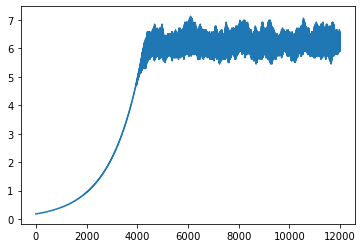

In [18]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(step_sizes)), step_sizes)
plt.show()
pass

In [19]:
epochs = 500

start_time = time.time()
for epoch in range(epochs):
    
    loss = 0.0
    acc = 0.0
    for bs, (x, y) in enumerate(train_ds):
        
        # only one mini-batch
        model.update_weights(x, network[bs], y, 0.1)
        
        network_new = []
        kernels_new = []
        for (xx, yy), net, hmc_kernel in zip(train_ds, network, kernels):
            net_current = net
            net_current = [tf.cast(net_i, dtype=tf.float32) for net_i in net_current]
            net_current = net_current[0]
        
            num_results = 1
            num_burnin_steps = 0

            samples = tfp.mcmc.sample_chain(
                num_results = num_results,
                num_burnin_steps = num_burnin_steps,
                current_state = net_current, # may need to be reshaped
                kernel = hmc_kernel,
                trace_fn = None,
                return_final_kernel_results = True)
            
            new_state = rerange(samples[0][0])
            net_new = tf.split(new_state, [100], axis = 1)   
            network_new.append(net_new)
            
            ker_new = model.generate_hmc_kernel(xx, yy, new_step_size)
            kernels_new.append(ker_new)
   
        network = network_new
        kernels = kernels_new
        
        loss += -1 * tf.reduce_mean(model.target_log_prob(x, network[bs], y))
    
    preds = [model.get_predictions(images) for images, labels in train_ds]
    train_acc = accuracy_score(np.concatenate(preds), y_train)
    print("Epoch %d/%d: - %.4fs/step - loss: %.4f - accuracy: %.4f" 
          % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), loss, train_acc))


Epoch 1/500: - 143.8309s/step - loss: 831.9352 - accuracy: 0.8133
Epoch 2/500: - 153.5084s/step - loss: 831.0690 - accuracy: 0.7867
Epoch 3/500: - 140.6002s/step - loss: 828.7038 - accuracy: 0.8107
Epoch 4/500: - 137.9144s/step - loss: 827.5698 - accuracy: 0.8080
Epoch 5/500: - 133.4961s/step - loss: 824.3521 - accuracy: 0.8053
Epoch 6/500: - 131.8092s/step - loss: 818.9186 - accuracy: 0.8000
Epoch 7/500: - 133.9004s/step - loss: 815.6720 - accuracy: 0.7947
Epoch 8/500: - 132.8059s/step - loss: 811.3766 - accuracy: 0.7920
Epoch 9/500: - 130.2984s/step - loss: 806.6678 - accuracy: 0.7787
Epoch 10/500: - 126.2892s/step - loss: 799.9056 - accuracy: 0.7893
Epoch 11/500: - 123.7138s/step - loss: 796.8919 - accuracy: 0.7840
Epoch 12/500: - 121.3784s/step - loss: 792.0732 - accuracy: 0.7840
Epoch 13/500: - 120.6962s/step - loss: 787.3805 - accuracy: 0.7813
Epoch 14/500: - 120.4453s/step - loss: 782.6754 - accuracy: 0.7840
Epoch 15/500: - 119.2423s/step - loss: 776.7366 - accuracy: 0.7893
Epoc